# Recherche du meilleur modèle CatBoostClassifier sur 2 classes

### Imports

In [1]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

## Import des scripts python
import sys
import os
sys.path.append(os.path.abspath('../../python_scripts/'))

#import load_datas
import train_model as train
import save_model as saveModel
#import pickle_model

# Rechargement en cas de modification
import importlib
importlib.reload(train)
importlib.reload(saveModel)
#importlib.reload(pickle_model)

<module 'save_model' from '/Users/thierno/Documents/DataScientest/Final_Project/MAR24_CDS_Accidents/Notebooks/Entrainements/python_scripts/save_model.py'>

### Chargement des datasets

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

pd.set_option('display.max_columns', None)

#df = pd.read_csv("../../data/accidents_data.zip", compression=dict(method='zip', archive_name='accidents_data.csv'))

#display(df.head())

#X = df.drop(columns=['grav'])
#y = df['grav']


X_train = pd.read_csv("../../../../Data/X_train.zip", compression=dict(method='zip', archive_name='X_train.csv'))
y_train = pd.read_csv("../../../../Data/y_train.zip", compression=dict(method='zip', archive_name='y_train.csv'))['grav']

X_test = pd.read_csv("../../../../Data/X_test.zip", compression=dict(method='zip', archive_name='X_test.csv'))
y_test = pd.read_csv("../../../../Data/y_test.zip", compression=dict(method='zip', archive_name='y_test.csv'))['grav']

print("X_train shape :",X_train.shape)
print("X_test shape :",X_test.shape)

y_train=y_train.replace({1:0})
y_train=y_train.replace({2:1,3:1})

y_test=y_test.replace({1:0})
y_test=y_test.replace({2:1,3:1})


X_train shape : (352893, 337)
X_test shape : (88224, 337)


### Rééquilibrage du dataset d'entrainement

In [3]:
from imblearn.under_sampling import RandomUnderSampler

ro = RandomUnderSampler(random_state=1024)
X_train_ru, y_train_ru = ro.fit_resample(X_train,y_train)

### CatBoostClassifier : modèle par défaut 

Temps d'entraînement : 9.75 seconds
Classification_Report: CatBoostClassifier_Default


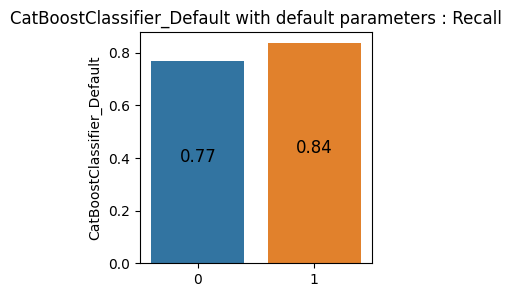

,0,1,Training_Time,Best_Params
CatBoostClassifier_Default,0.769856,0.836465,9.747046,Default


(<catboost.core.CatBoostClassifier at 0x14502ac90>,
                                    0         1  Training_Time Best_Params
 CatBoostClassifier_Default  0.769856  0.836465       9.747046     Default)

In [4]:
from catboost import CatBoostClassifier

train.fit("CatBoostClassifier_Default",
          CatBoostClassifier(verbose=0,random_state=42),
          X_train_ru,
          y_train_ru,
          X_test,
          y_test)



### CatBoostClassifier : Grid Search

/Users/thierno/Documents/DataScientest/Final_Project/MAR24_CDS_Accidents/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Temps d'entraînement : 16.13 minutes
Classification_Report: CatBoostClassifier_Grid


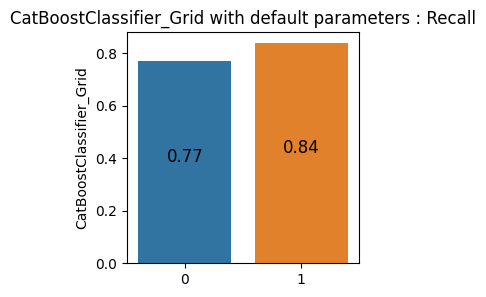

*** Best Param : {'depth': 10, 'iterations': 1500, 'learning_rate': 0.03} ***


,0,1,Training_Time,Best_Params
CatBoostClassifier_Grid,0.770998,0.838472,967.769675,"{'depth': 10, 'iterations': 1500, 'learning_ra..."


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from catboost import  CatBoostClassifier

param_grid = {
    'iterations': [500, 1000, 1500],          # Nombre d'itérations (nombre d'arbres)
    'learning_rate': [0.03,0.1,0.3],      # Taux d'apprentissage
    'depth': [6, 8, 10]                     # Profondeur des arbres
    #,'l2_leaf_reg': [1, 3, 5]               # Régularisation L2
   # ,'bagging_temperature': [0.5, 1, 2]     # Température pour le bootstrap
   # ,'random_strength': [1, 2, 3]           # Force du bruit ajouté
   # ,'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']  # Politique de croissance
}

best_model, df_result = train.fit_grid_search("CatBoostClassifier_Grid",
                               CatBoostClassifier(verbose=0,random_state=42),
                               param_grid,
                               5,
                               X_train_ru,
                               y_train_ru,
                               X_test,
                               y_test)



### Sauvegarde du meilleur modèle 

In [6]:
import joblib

file_name = "best_models/catboost_2_classes.gz"
saveModel.save(best_model, file_name)
#joblib.dump(best_model, model_filename_gz, compress=("bz2", 3))

#joblib.dump(best_model, 'best_models/random_forest_4_classes.joblib')


### Test du chargement du modèle sauvegardé

In [7]:
from sklearn.metrics import classification_report

# Chargement du modele
#model = joblib.load(model_filename_gz)
model = saveModel.load(file_name)
# Prediction du model
y_pred = model.predict(X_test)

# Évaluation du modèle
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.77      0.85     71781
           1       0.46      0.84      0.59     16443

    accuracy                           0.78     88224
   macro avg       0.71      0.80      0.72     88224
weighted avg       0.86      0.78      0.80     88224

